# XJTU battery dataset analysis

# 电池和实验介绍
本实验的实验对象为“力神”制造的18650型镍钴锰酸锂电池，其化学成分为$\text{LiNi}_{0.5}\text{Co}_{0.2}\text{Mn}_{0.3}\text{O}_2$。
电池的标称容量为2000 mAh，标称电压为3.6 V，充电截止电压和放电截止电压分别为4.2 V和2.5 V。整个实验在室温下进行。
充放电设备为ACTS-5V10A-GGS-D，所有数据的采样频率为1Hz。


# 代码


In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.io import loadmat
from scipy import interpolate
import os
import functools

插值重采样装饰器

In [2]:
def interpolate_resample(resample=True, num_points=128):
    '''
    插值重采样装饰器,如果resample为True，那么就进行插值重采样，点数为num_points,默认为128；
    否则就不进行重采样
    :param resample: bool: 是否进行重采样
    :param num_points: int: 重采样的点数
    :return:
    '''
    def decorator(func):
        @functools.wraps(func)
        def wrapper(self,*args, **kwargs):
            data = func(self,*args, **kwargs)
            if resample:
                x = np.linspace(0, 1, data.shape[0])
                f1 = interpolate.interp1d(x, data, kind='linear')
                new_x = np.linspace(0, 1, num_points)
                data = f1(new_x)
            return data
        return wrapper
    return decorator

Battery类，它可以用于读取XJTU电池数据集所有batch的数据

In [3]:
class Battery:
    def __init__(self,path):
        mat = loadmat(path)
        self.data = mat['data']
        self.battery_name = path.split('/')[-1].split('.')[0]
        self.summary = mat['summary']
        self.cycle_life = self.summary[0][0][8][0][0]
        self.description = self.summary[0][0][9][0]
        self.variable_name = ['system_time','relative_time_min','voltage_V','current_A','capacity_Ah','power_Wh','temperature_C','description']
        print(f'电池寿命：{self.cycle_life}, 电池描述：{self.description}')

    def print_variable_name(self):
        print('0:system_time, '
              '1:relative_time_min, '
              '2:voltage_V, '
              '3:current_A, '
              '4:capacity_Ah, '
              '5:power_Wh, '
              '6:temperature_C, '
              '7:description'
              )

    def get_descriptions(self):
        '''
        电池每个cycle都有一个描述，这个函数返回所有的描述种类
        :return:
        '''
        descriptions = []
        for i in range(self.data.shape[1]):
            description = self.data[0][i][7][0]
            if description not in descriptions:
                descriptions.append(description)
        return descriptions

    def get_one_cycle_description(self,cycle):
        '''
        获取某个cycle的描述
        :param cycle: int: 电池的循环次数
        :return:
        '''
        # 如果cycle大于电池的循环次数，或者小于1，那么就报错，并提示用户
        if cycle > self.data.shape[1] or cycle < 1:
            raise ValueError(f'cycle的值应该在[1,{self.data.shape[1]}]之内')
        description = self.data[0][cycle-1][7][0]
        return description

    def get_degradation_trajectory(self):
        '''
        获取电池的容量衰减轨迹。因为很多cycle没有完全放电，因此需要用[test capacity]的cycle来插值
        对于完全放电的前几批次数据，该函数与self.get_capacity()函数的结果是一样的
        :return:
        '''
        # 获取测量容量的cycle
        test_capacity_cycles = []
        for i in range(1,self.cycle_life+1):
            des = self.get_one_cycle_description(i)
            if 'test capacity' in des:
                test_capacity_cycles.append(i)
        # 获取测量容量的cycle的容量
        index = np.array(test_capacity_cycles)-1
        capacity = self.get_capacity()
        test_capacity = capacity[index]

        # 利用插值法获取所有cycle的容量
        cycle = np.arange(1,self.cycle_life+1)
        try:
            f = interpolate.interp1d(test_capacity_cycles,test_capacity,kind='cubic',fill_value='extrapolate')
        except:
            f = interpolate.interp1d(test_capacity_cycles,test_capacity,kind='linear',fill_value='extrapolate')
        degradation_trajectory = f(cycle)
        return degradation_trajectory #,(np.array(test_capacity_cycles),test_capacity)

    def get_capacity(self):
        '''
        获取电池的容量曲线
        :return:
        '''
        capacity = self.summary[0][0][1].reshape(-1)
        return capacity

    def get_value(self,cycle,variable):
        '''
        从cycle中提取出variable的数据
        :param cycle: int: 电池的循环次数
        :param variable: int or str: 变量的名称或者索引,可选self.variable_name中的变量
        :return:
        '''
        if isinstance(variable,str):
            variable = self.variable_name.index(variable)
        assert cycle <= self.data.shape[1]
        assert variable <= 7
        value = self.data[0][cycle-1][variable]
        if variable == 7:
            value = value[0]
        else:
            value = value.reshape(-1)
        return value

    # 如果需要重采样，则取消下面这行注释
    # @interpolate_resample(resample=False,num_points=128)
    def get_partial_value(self,cycle,variable,stage=1):
        '''
        从cycle中提取出variable的stage阶段的数据
        :param cycle: int: 电池的循环次数
        :param variable: int or str: 变量的名称或者索引,可选self.variable_name中的变量
        :param stage: int: 阶段的索引，可选[1,2,3,4], 分别是【充电，静置，放电，静置】; 对于Batch6模拟卫星的实验数据，一共有三个阶段[1,2,3]，【分别是充电，静置，放电】
        :return:
        '''
        value = self.get_value(cycle=cycle,variable=variable)
        relative_time_min = self.get_value(cycle=cycle,variable='relative_time_min')
        # 找到relative_time_min中等于0的index
        index = np.where(relative_time_min == 0)[0]
        index = np.insert(index,len(index),len(value))
        value = value[index[stage-1]:index[stage]]
        return value

    # 如果需要重采样，则取消下面这行注释
    # @interpolate_resample(resample=False,num_points=128)
    def get_CC_value(self, cycle, variable, voltage_range=None):
        '''
        获取第cycle个充电的周期的CC过程中的variable的值;如果指定了voltage_range,那么就是在voltage_range范围内的值
        :param cycle: int: 电池的循环次数
        :param variable: int or str: 变量的名称或者索引,可选self.variable_name中的变量
        :param voltage_range: list or None: 电压的范围,默认为None,表示整个CC过程的数据. 也可选其他范围，for example:[3.5,4.0]
        :return:
        '''
        value = self.get_partial_value(cycle=cycle, variable=variable, stage=1)
        voltage = self.get_partial_value(cycle=cycle, variable='voltage_V', stage=1)
        if voltage_range is None:
            index = np.where(voltage <= 4.199)[0]
        else:
            index = np.where((voltage >= voltage_range[0]) & (voltage <= voltage_range[1]))[0]
        value = value[index]
        return value

    # 如果需要重采样，则取消下面这行注释
    # @interpolate_resample(resample=False,num_points=128)
    def get_CV_value(self, cycle, variable, current_range=None):
        '''
        获取第cycle个充电的周期的CV过程中的variable的值;如果指定了current_range,那么就是在current_range范围内的值
        :param cycle: int: 电池的循环次数
        :param variable: int or str: 变量的名称或者索引,可选self.variable_name中的变量
        :param current_range: list or None: 电流的范围,默认为None,表示整个CV过程的数据. 其他可选：for example:[1.0,0.5]
        :return:
        '''
        value = self.get_partial_value(cycle=cycle, variable=variable, stage=1)
        current = self.get_partial_value(cycle=cycle, variable='current_A', stage=1)
        voltage = self.get_partial_value(cycle=cycle, variable='voltage_V', stage=1)
        if current_range is None:
            index = np.where(voltage >= 4.199)[0]
        else:
            index = np.where((current >= np.min(current_range)) & (current <= np.max(current_range)))[0]
        value = value[index]
        return value

    def get_one_cycle(self,cycle):
        '''
        获取某个cycle的所有通道数据
        :param cycle: int: 电池的循环次数
        :return:
        '''
        assert cycle <= self.data.shape[1]
        cycle_data = {}
        cycle_data['system_time'] = self.get_value(cycle=cycle,variable='system_time')
        cycle_data['relative_time_min'] = self.get_value(cycle=cycle,variable='relative_time_min')
        cycle_data['voltage_V'] = self.get_value(cycle=cycle,variable='voltage_V')
        cycle_data['current_A'] = self.get_value(cycle=cycle,variable='current_A')
        cycle_data['capacity_Ah'] = self.get_value(cycle=cycle,variable='capacity_Ah')
        cycle_data['power_Wh'] = self.get_value(cycle=cycle,variable='power_Wh')
        cycle_data['temperature_C'] = self.get_value(cycle=cycle,variable='temperature_C')
        cycle_data['description'] = self.get_value(cycle=cycle,variable='description')
        return cycle_data

    def get_IC_curve1(self,cycle,voltage_range=[3.6,4.19],step_len=0.01):
        '''
        计算增量容量曲线，公式为：dQ/dV,其中Q为容量，V为电压
        :param cycle: int: 电池的循环次数
        :param voltage_range: list: 电压的范围,默认为None,表示整个电池的电压范围
        :param step_len: float: 对容量数据进行等电压的间隔重采样，默认电压间隔为0.01V
        :return:
        '''
        Q = self.get_CC_value(cycle=cycle,variable='capacity_Ah',voltage_range=voltage_range)
        V = self.get_CC_value(cycle=cycle,variable='voltage_V',voltage_range=voltage_range)

        if len(Q) <= 2 or len(V) <= 2:
            return [],[]

        # 对Q进行等V间隔重采样
        f1 = interpolate.interp1d(V, Q, kind='linear')
        num_points = int((voltage_range[1] - voltage_range[0]) / step_len) + 1
        V_new = np.linspace(V[0], V[-1], num_points)
        Q_new = f1(V_new)

        dQ = np.diff(Q_new)
        dV = np.diff(V_new)
        IC = dQ/dV

        return IC,V_new[1:]

    def get_IC_curve2(self,cycle,voltage_range=[3.6,4.19],step_len=0.01):
        '''
        计算增量容量曲线，公式为：dQ/dV = I·dt/dV
        :param cycle: int: 电池的循环次数
        :param voltage_range: list: 电压的范围,默认为None,表示整个电池的电压范围
        :param step_len: float: 对电流和时间数据进行等电压的间隔重采样，默认电压间隔为0.01V
        :return:
        '''
        t = self.get_CC_value(cycle=cycle,variable='relative_time_min',voltage_range=voltage_range)
        V = self.get_CC_value(cycle=cycle,variable='voltage_V',voltage_range=voltage_range)
        I = self.get_CC_value(cycle=cycle,variable='current_A',voltage_range=voltage_range)

        # 对t和I进行等电压V间隔重采样
        num_points = int((voltage_range[1] - voltage_range[0]) / step_len) + 1
        f1 = interpolate.interp1d(V, t, kind='linear')
        V_new = np.linspace(V[0], V[-1], num_points)
        t_new = f1(V_new)
        f2 = interpolate.interp1d(V, I, kind='linear')
        I_new = f2(V_new)

        dt = np.diff(t_new)
        dV = np.diff(V_new)
        Idt = I_new[1:]*dt
        IC = Idt/dV
        return IC,V_new[1:]

在上面的代码的基础上，我们分别对每个batch的数据进行可视化。
注：下面所画的图都可以调用`Battery`类中的函数获取数据。

# Batch-1
## 数据介绍
**固定充放电策略，充满，放完。**
第一个cycle测量电池的初始容量：
以0.5C（1A）恒流充电至4.2V，然后维持电压不变，直至电流降至0.02C（40mA）；
静置5分钟；以0.2C（0.4A）放电至2.5V。

其他cycles：
1. 以2.0C（4A）恒流充电至4.2V，然后维持电压不变，直至电流降至0.05C（0.1A）；
2. 静置5分钟；
3. 以1.0C（2A）放电至2.5V；
4. 静置5分钟。


## 案例和可视化

In [4]:
# Batch1
battery_path = r'..\Batch-1\2C_battery-1.mat'
battery = Battery(battery_path)

电池寿命：390, 电池描述：2C charge experiment


### 画容量退化曲线


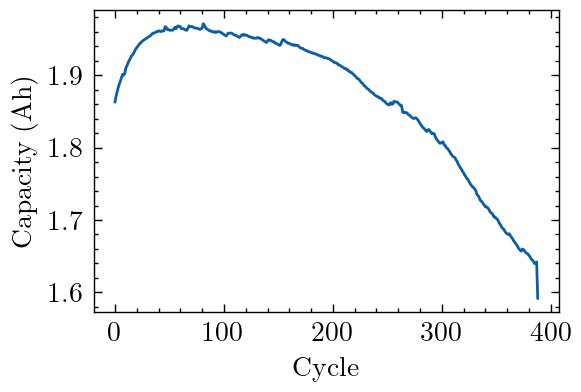

In [5]:
# 画容量退化曲线
import scienceplots
plt.style.use(['science'])
%matplotlib inline
degradation_trajectory = battery.get_capacity()
fig, ax = plt.subplots(figsize=(3, 2),dpi=200)
plt.plot(degradation_trajectory[1:])
plt.xlabel('Cycle')
plt.ylabel('Capacity (Ah)')
plt.show()

### 画任意一个cycle的电压、电流、温度曲线

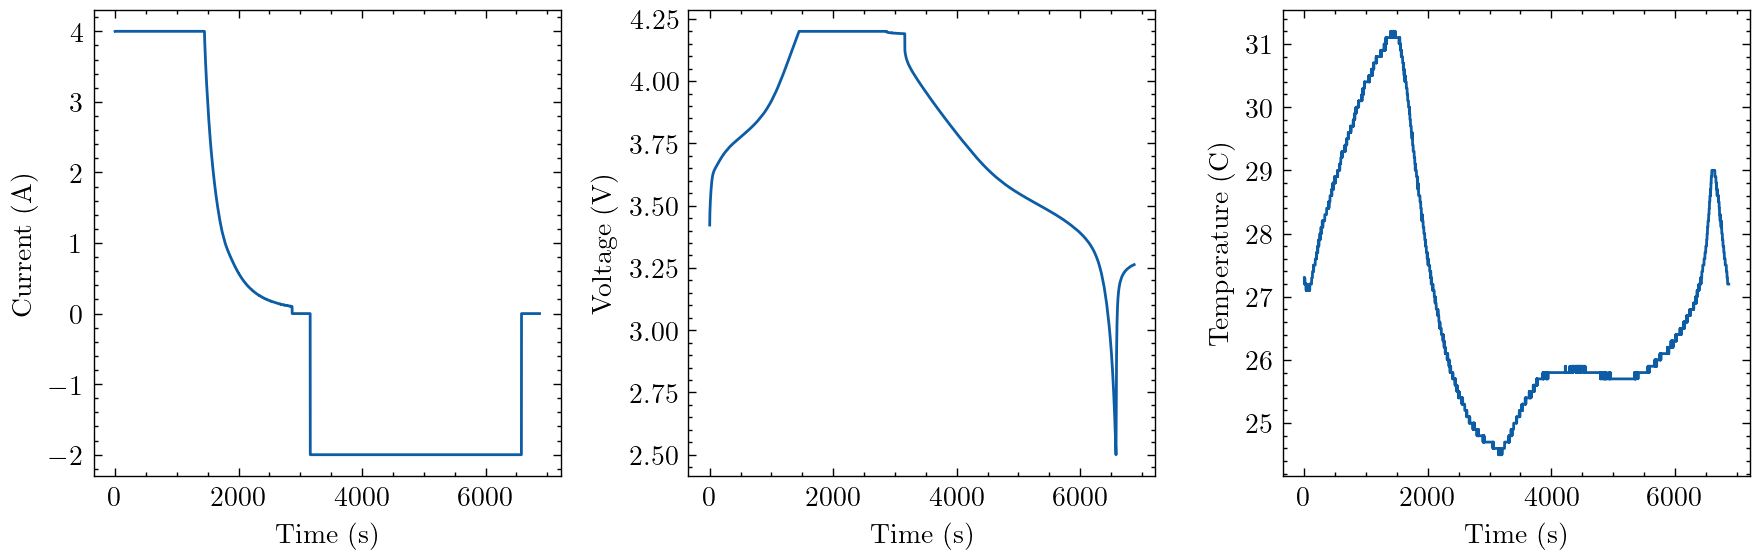

In [6]:
# 画第100个cycle的电压、电流、温度曲线
current = battery.get_value(cycle=100,variable='current_A')
voltage = battery.get_value(cycle=100,variable='voltage_V')
temperature = battery.get_value(cycle=100,variable='temperature_C')
# 在1*3的子图中画出电压、电流、温度曲线
fig, axs = plt.subplots(1, 3, figsize=(9, 3),dpi=200)
axs[0].plot(current)
axs[0].set_xlabel('Time (s)')
axs[0].set_ylabel('Current (A)')
axs[1].plot(voltage)
axs[1].set_xlabel('Time (s)')
axs[1].set_ylabel('Voltage (V)')
axs[2].plot(temperature)
axs[2].set_xlabel('Time (s)')
axs[2].set_ylabel('Temperature (C)')
plt.tight_layout()
plt.show()

### 画任意一个cycle的【充电阶段】的电压、电流、温度曲线

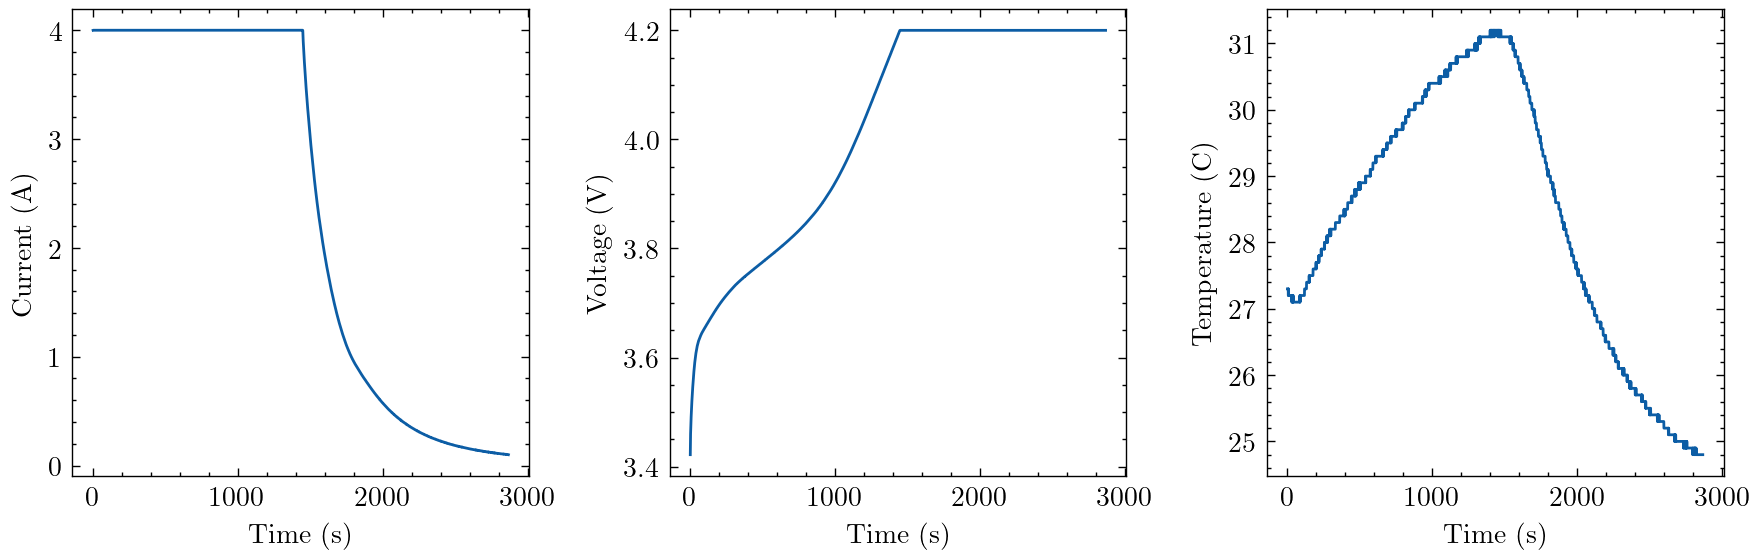

In [7]:
# 画第100个cycle的充电阶段的电压、电流、温度曲线
current = battery.get_partial_value(cycle=100,stage=1,variable='current_A')
voltage = battery.get_partial_value(cycle=100,stage=1,variable='voltage_V')
temperature = battery.get_partial_value(cycle=100,stage=1,variable='temperature_C')
# 在1*3的子图中画出电压、电流、温度曲线
fig, axs = plt.subplots(1, 3, figsize=(9, 3),dpi=200)
axs[0].plot(current)
axs[0].set_xlabel('Time (s)')
axs[0].set_ylabel('Current (A)')
axs[1].plot(voltage)
axs[1].set_xlabel('Time (s)')
axs[1].set_ylabel('Voltage (V)')
axs[2].plot(temperature)
axs[2].set_xlabel('Time (s)')
axs[2].set_ylabel('Temperature (C)')
plt.tight_layout()
plt.show()

### 画任意一个cycle的【放电阶段】的电压、电流、温度曲线

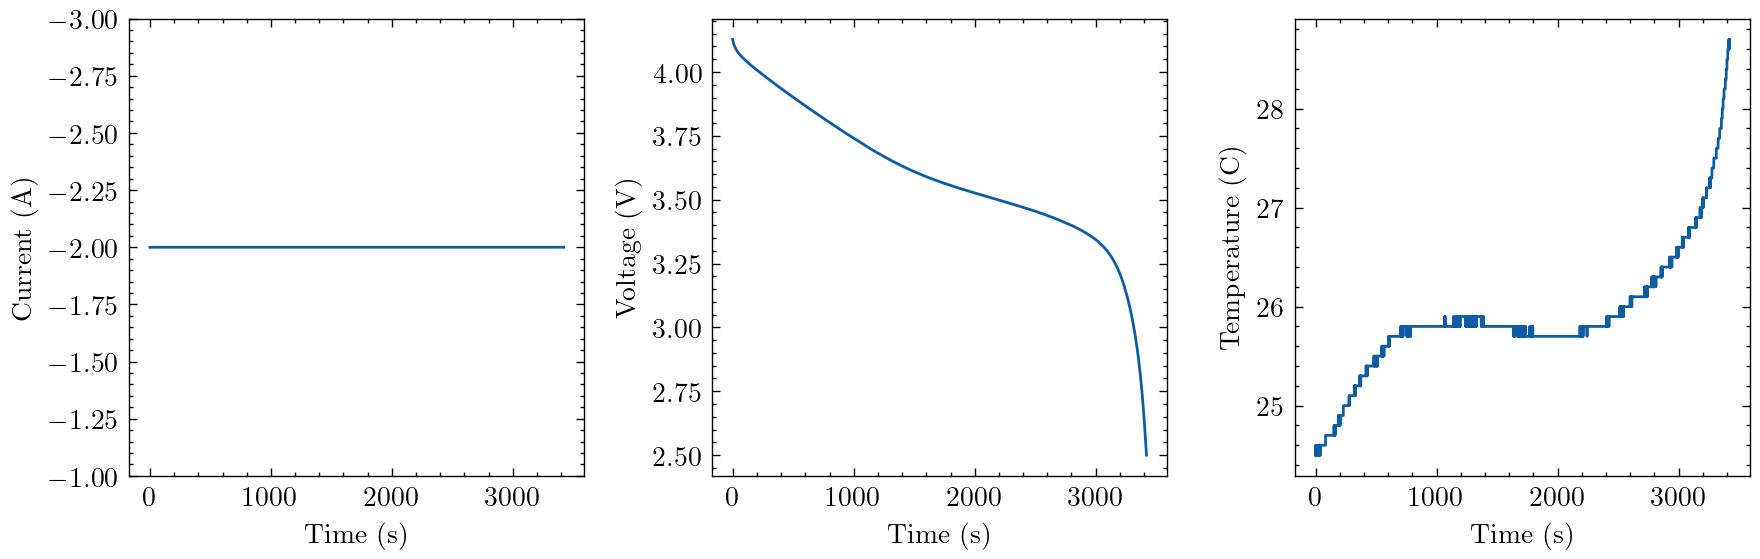

In [8]:
# 画第100个cycle的放电阶段的电压、电流、温度曲线
current = battery.get_partial_value(cycle=100,stage=3,variable='current_A')
voltage = battery.get_partial_value(cycle=100,stage=3,variable='voltage_V')
temperature = battery.get_partial_value(cycle=100,stage=3,variable='temperature_C')
# 在1*3的子图中画出电压、电流、温度曲线
fig, axs = plt.subplots(1, 3, figsize=(9, 3),dpi=200)
axs[0].plot(current)
axs[0].set_ylim([-1,-3])
axs[0].set_xlabel('Time (s)')
axs[0].set_ylabel('Current (A)')
axs[1].plot(voltage)
axs[1].set_xlabel('Time (s)')
axs[1].set_ylabel('Voltage (V)')
axs[2].plot(temperature)
axs[2].set_xlabel('Time (s)')
axs[2].set_ylabel('Temperature (C)')
plt.tight_layout()
plt.show()

### 画任意一个cycle的【恒流充电】阶段的曲线，可指定电压范围

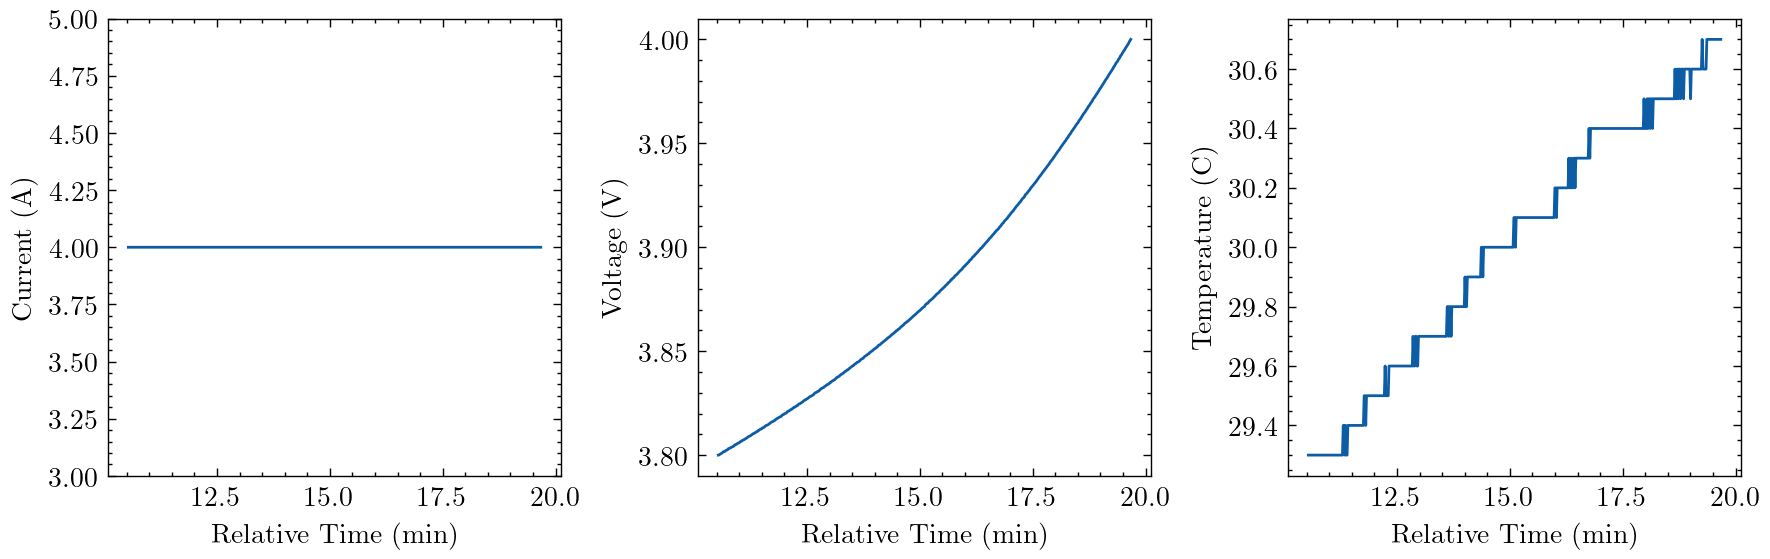

In [9]:
# 画第100个cycle恒流充电阶段，电压范围为[3.8,4.0]的电压、电流、温度曲线
relative_time = battery.get_CC_value(cycle=100,variable='relative_time_min',voltage_range=[3.8,4.0])
current = battery.get_CC_value(cycle=100,variable='current_A',voltage_range=[3.8,4.0])
voltage = battery.get_CC_value(cycle=100,variable='voltage_V',voltage_range=[3.8,4.0])
temperature = battery.get_CC_value(cycle=100,variable='temperature_C',voltage_range=[3.8,4.0])
# 在1*3的子图中画出电压、电流、温度曲线
fig, axs = plt.subplots(1, 3, figsize=(9, 3),dpi=200)
axs[0].plot(relative_time,current)
axs[0].set_ylim([3,5])
axs[0].set_xlabel('Relative Time (min)')
axs[0].set_ylabel('Current (A)')
axs[1].plot(relative_time,voltage)
axs[1].set_xlabel('Relative Time (min)')
axs[1].set_ylabel('Voltage (V)')
axs[2].plot(relative_time,temperature)
axs[2].set_xlabel('Relative Time (min)')
axs[2].set_ylabel('Temperature (C)')
plt.tight_layout()
plt.show()

### 画任意一个cycle的【恒压充电】阶段的曲线，可指定电流范围

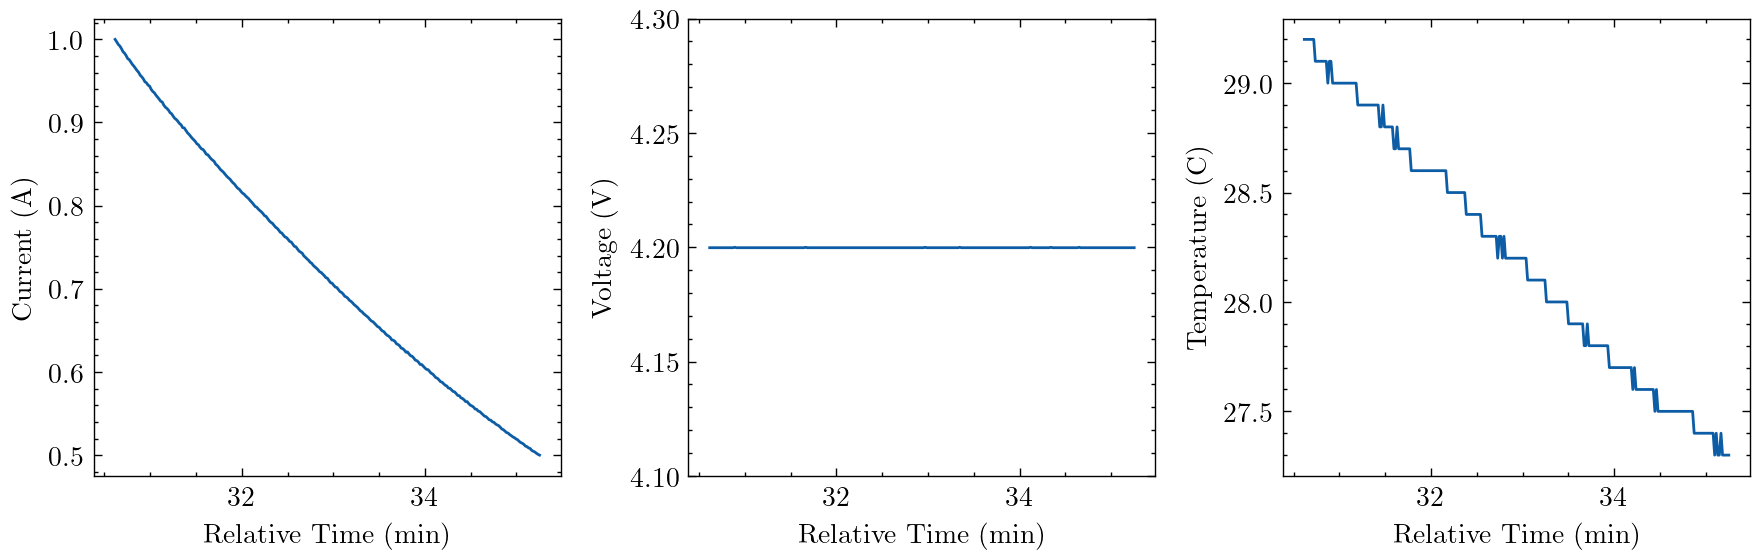

In [10]:
# 画第100个cycle恒压充电阶段，电流范围为[1.0,0.5]A内的电压、电流、温度曲线
relative_time = battery.get_CV_value(cycle=100,variable='relative_time_min',current_range=[1.0,0.5])
current = battery.get_CV_value(cycle=100,variable='current_A',current_range=[1.0,0.5])
voltage = battery.get_CV_value(cycle=100,variable='voltage_V',current_range=[1.0,0.5])
temperature = battery.get_CV_value(cycle=100,variable='temperature_C',current_range=[1.0,0.5])
# 在1*3的子图中画出电压、电流、温度曲线
fig, axs = plt.subplots(1, 3, figsize=(9, 3),dpi=200)
axs[0].plot(relative_time,current)
axs[0].set_xlabel('Relative Time (min)')
axs[0].set_ylabel('Current (A)')
axs[1].plot(relative_time,voltage)
axs[1].set_xlabel('Relative Time (min)')
axs[1].set_ylabel('Voltage (V)')
axs[1].set_ylim([4.1,4.3])
axs[2].plot(relative_time,temperature)
axs[2].set_xlabel('Relative Time (min)')
axs[2].set_ylabel('Temperature (C)')
plt.tight_layout()
plt.show()

### 画任意一个cycle的增量容量曲线

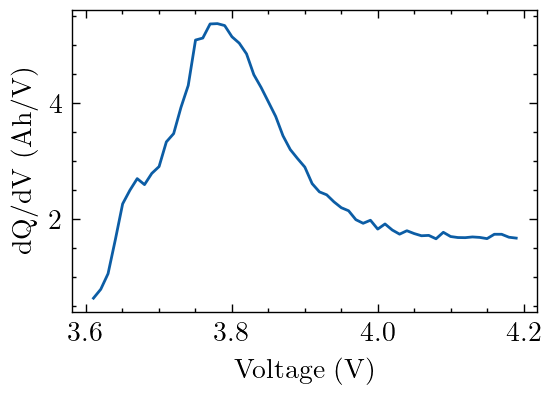

In [11]:
# 画第100个cycle的增量容量曲线
IC,V = battery.get_IC_curve1(cycle=100,voltage_range=[3.6,4.19],step_len=0.01)
fig, ax = plt.subplots(figsize=(3, 2),dpi=200)
plt.plot(V,IC)
plt.xlabel('Voltage (V)')
plt.ylabel('dQ/dV (Ah/V)')
plt.show()

### 画全寿命周期内的充电电压曲线

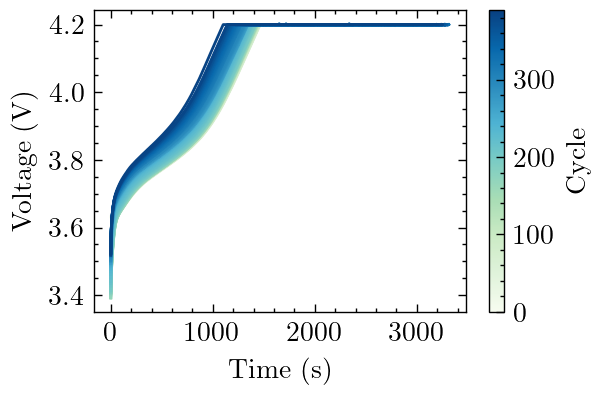

In [12]:
# 画全寿命周期内的充电电压曲线
fig, ax = plt.subplots(figsize=(3, 2),dpi=200)
cm = plt.cm.GnBu(np.linspace(0,1,battery.cycle_life))
sm = plt.cm.ScalarMappable(cmap='GnBu',norm=plt.Normalize(vmin=0,vmax=battery.cycle_life))
for cycle in range(1,battery.cycle_life+1,5):
    voltage = battery.get_partial_value(cycle=cycle,stage=1,variable='voltage_V')
    plt.plot(voltage,color=cm[cycle-1])
plt.xlabel('Time (s)')
plt.ylabel('Voltage (V)')
cbar = plt.colorbar(sm)
cbar.set_label('Cycle')
plt.show()

同理，改变以上代码可以画出其他的曲线，例如增量容量曲线:

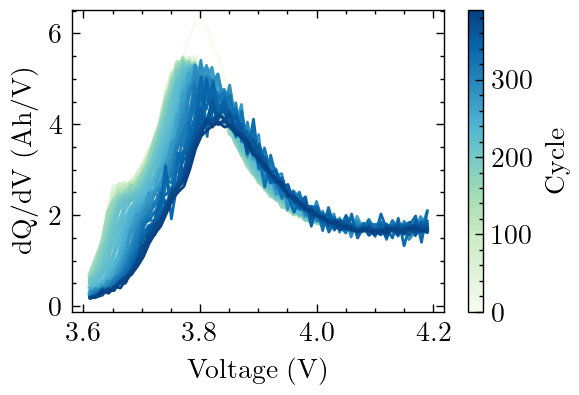

In [13]:
fig, ax = plt.subplots(figsize=(3, 2),dpi=200)
cm = plt.cm.GnBu(np.linspace(0,1,battery.cycle_life))
sm = plt.cm.ScalarMappable(cmap='GnBu',norm=plt.Normalize(vmin=0,vmax=battery.cycle_life))
for cycle in range(2,battery.cycle_life+1,5):
    IC,V = battery.get_IC_curve1(cycle=cycle,voltage_range=[3.6,4.19],step_len=0.01)
    plt.plot(V,IC,color=cm[cycle-1])
plt.xlabel('Voltage (V)')
plt.ylabel('dQ/dV (Ah/V)')
cbar = plt.colorbar(sm)
cbar.set_label('Cycle')
plt.show()

注：以上所有的图都没有经过重采样，如果需要重采样，可以取消相应函数的注释。

# Batch-2
## 数据集介绍
**固定充放电策略，充满，放完。**
第一个cycle测量电池的初始容量：以0.5C（1A）恒流充电至4.2V，然后维持电压不变，直至电流降至0.02C（40mA）；
静置5分钟；以0.2C（0.4A）放电至2.5V。

其他cycles：
1. 以3.0C（A）恒流充电至4.2V，然后维持电压不变，直至电流降至0.05C（0.1A）；
2. 静置5分钟；
3. 以1.0C（2A）放电至2.5V；
4. 静置5分钟。


## 案例和可视化
Batch-2的数据集和Batch-1的数据集类似，可以参考Batch-1的案例和可视化

# Batch-3
## 数据集介绍
**不固定放电策略，充满，放完。**
第一个cycle测量电池的初始容量：以0.5C（1A）恒流充电至4.2V，然后维持电压不变，直至电流降至0.02C（40mA）；
静置5分钟；以0.2C（0.4A）放电至2.5V。

其他cycles：
1. 以2.0C（2A）恒流充电至4.2V，然后维持电压不变，直至电流降至0.05C（0.1A）；
2. 静置5分钟；
3. 以$x$C放电至2.5V（$x$在{0.5,1,2,3,5}中循环取值）；
4. 静置5分钟；

## 案例和可视化

In [14]:
battery = Battery('../Batch-3/R2.5_battery-1.mat')
cm = plt.cm.GnBu(np.linspace(0,1,battery.cycle_life))
sm = plt.cm.ScalarMappable(cmap='GnBu',norm=plt.Normalize(vmin=0,vmax=battery.cycle_life))

电池寿命：592, 电池描述：Random discharge to 2.5V


### 画容量退化曲线

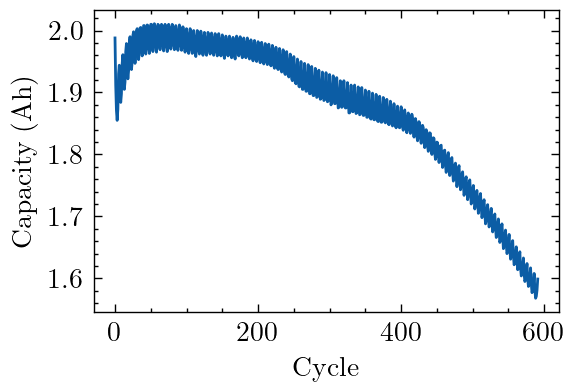

In [15]:
# 画容量退化曲线
degradation_trajectory = battery.get_capacity()
fig, ax = plt.subplots(figsize=(3, 2),dpi=200)
plt.plot(degradation_trajectory)
plt.xlabel('Cycle')
plt.ylabel('Capacity (Ah)')
plt.show()

从上图可以看出，由于放电电量依次在{0.5,1,2,3,5}C中循环取值，因此放出的电量不同，导致容量退化曲线波动较大。

### 画电压、电流、温度曲线
在一张图上画出放电电流取值{0.5,1,2,3,5}C的电压、电流、温度曲线

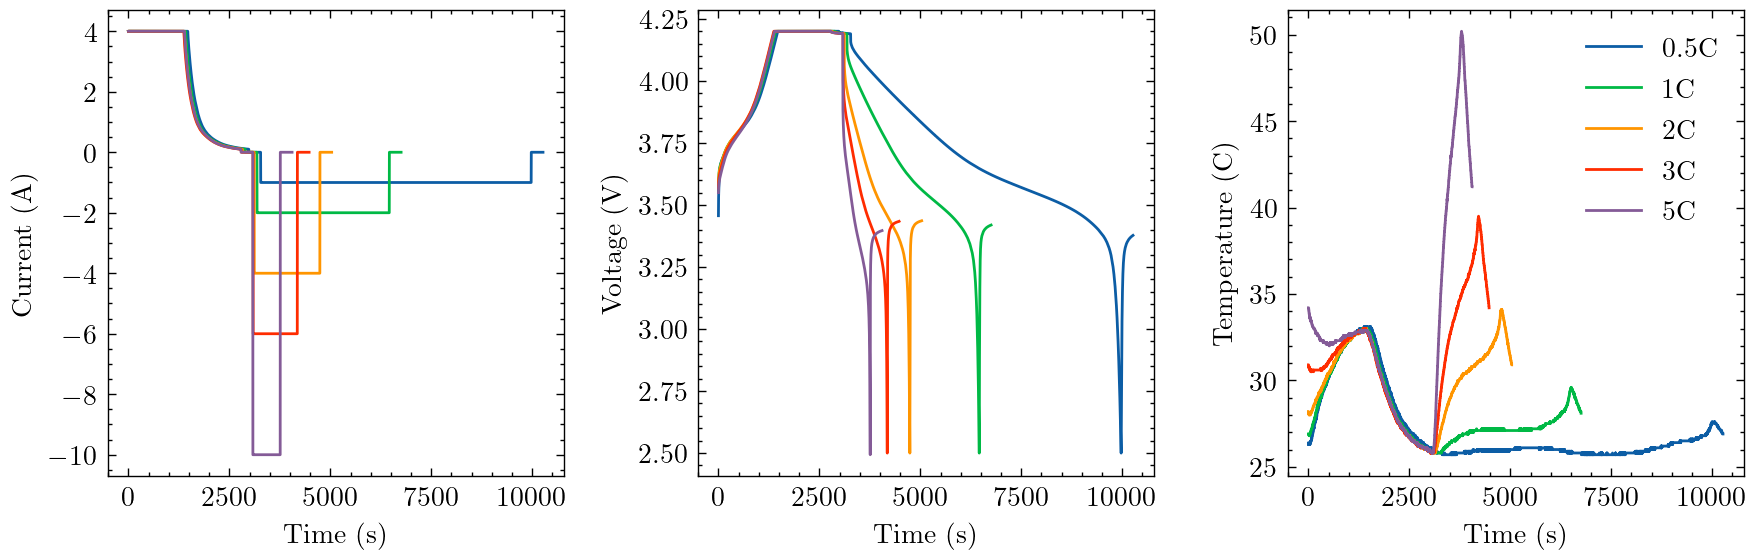

In [16]:
# 在1*3的图中画放电电流取值{0.5,1,2,3,5}C的电压、电流、温度曲线
fig, axs = plt.subplots(1, 3, figsize=(9, 3),dpi=200)
labels = ['0.5C','1C','2C','3C','5C']
for cycle in [2,3,4,5,6]:
    current = battery.get_value(cycle=cycle,variable='current_A')
    voltage = battery.get_value(cycle=cycle,variable='voltage_V')
    temperature = battery.get_value(cycle=cycle,variable='temperature_C')

    axs[0].plot(current)
    axs[0].set_xlabel('Time (s)')
    axs[0].set_ylabel('Current (A)')
    axs[1].plot(voltage)
    axs[1].set_xlabel('Time (s)')
    axs[1].set_ylabel('Voltage (V)')
    axs[2].plot(temperature,label=labels[cycle-2])
    axs[2].set_xlabel('Time (s)')
    axs[2].set_ylabel('Temperature (C)')
plt.legend()
plt.tight_layout()
plt.show()


### 其他曲线的画法与Batch-1一致，不再赘述。

# Batch-4
## 数据集介绍
**不固定放电策略，充满，不放完。**
第一个cycle测量电池的初始容量：以0.5C（1A）恒流充电至4.2V，然后维持电压不变，直至电流降至0.02C（40mA）；
静置5分钟；以0.2C（0.4A）放电至2.5V。

其他cycles：
1. 以2.0C（2A）恒流充电至4.2V，然后维持电压不变，直至电流降至0.05C（0.1A）；
2. 静置5分钟；
3. 以$x$C放电至3.0V（$x$在{0.5,1,2,3,5}中循环取值）；
4. 静置5分钟；
每当$x$循环完一轮，执行一次以下操作测量容量：以2C（4A）恒流恒压充电至4.2V；静置5分钟；以1C（2A）放电至2.5V；静置5分钟；


## 案例和可视化

In [17]:
battery = Battery('../Batch-4/R3_battery-1.mat')
cm = plt.cm.GnBu(np.linspace(0,1,battery.cycle_life))
sm = plt.cm.ScalarMappable(cmap='GnBu',norm=plt.Normalize(vmin=0,vmax=battery.cycle_life))

电池寿命：799, 电池描述：Random discharge to 3V


### 画容量退化曲线和退化轨迹
从Batch-4开始，所有电池都没有完全放电，因此用测试容量的cycle来插值，得到退化曲线。

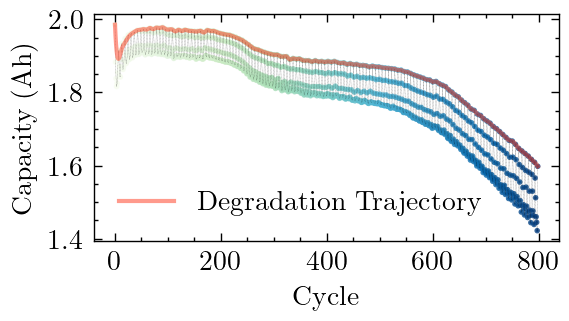

In [18]:
# 画容量退化曲线和退化轨迹
capacity = battery.get_capacity()
degradation_trajectory = battery.get_degradation_trajectory()
x = np.arange(len(capacity))
fig, ax = plt.subplots(figsize=(3, 1.5),dpi=200)
plt.plot(x,capacity,'--k',linewidth=0.1,alpha=0.6)
plt.scatter(x,capacity,c=cm,s=1,alpha=0.8)
plt.plot(degradation_trajectory,linewidth=1.5,alpha=0.5,c='#FF371B',label='Degradation Trajectory')
plt.xlabel('Cycle')
plt.ylabel('Capacity (Ah)')
plt.legend()
plt.show()

### 画电压、电流、温度曲线
在一张图上画出放电电流取值{0.5,1,2,3,5}C的电压、电流、温度曲线

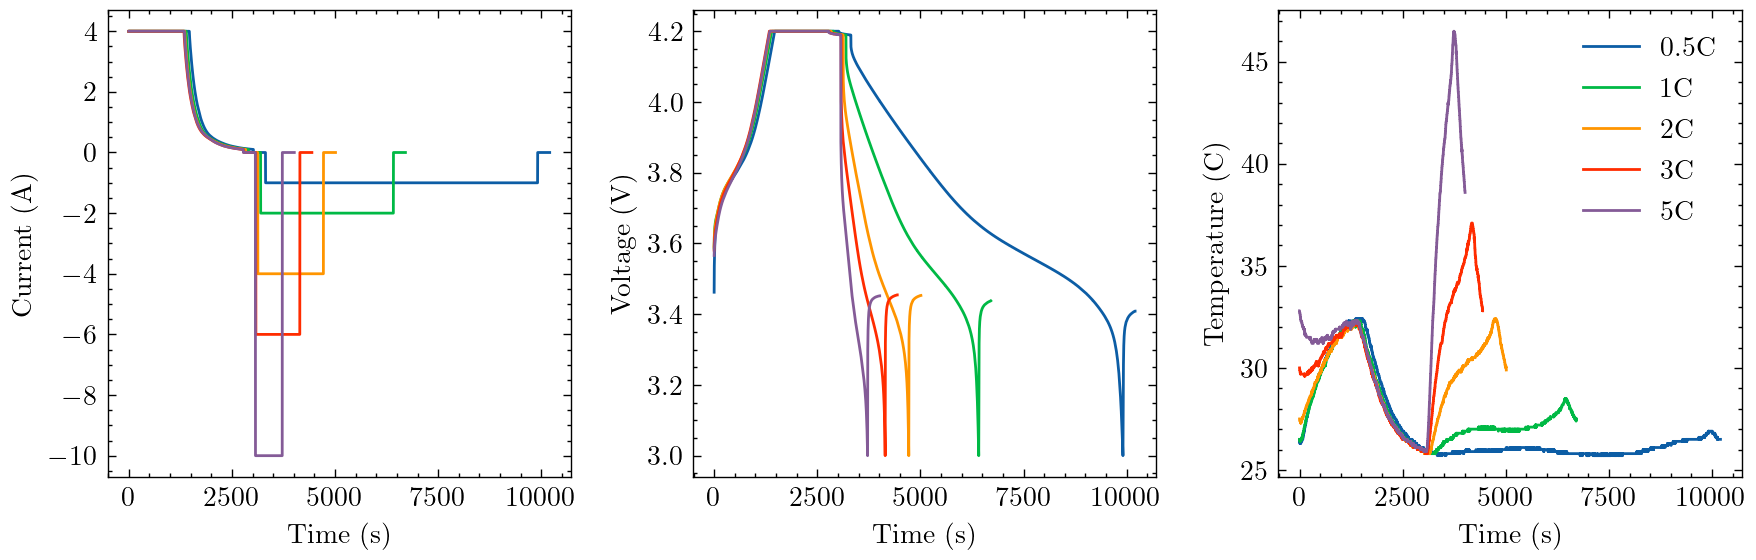

In [19]:
# 在1*3的图中画放电电流取值{0.5,1,2,3,5}C的电压、电流、温度曲线
fig, axs = plt.subplots(1, 3, figsize=(9, 3),dpi=200)
labels = ['0.5C','1C','2C','3C','5C']
for cycle in [2,3,4,5,6]:
    current = battery.get_value(cycle=cycle,variable='current_A')
    voltage = battery.get_value(cycle=cycle,variable='voltage_V')
    temperature = battery.get_value(cycle=cycle,variable='temperature_C')

    axs[0].plot(current)
    axs[0].set_xlabel('Time (s)')
    axs[0].set_ylabel('Current (A)')
    axs[1].plot(voltage)
    axs[1].set_xlabel('Time (s)')
    axs[1].set_ylabel('Voltage (V)')
    axs[2].plot(temperature,label=labels[cycle-2])
    axs[2].set_xlabel('Time (s)')
    axs[2].set_ylabel('Temperature (C)')
plt.legend()
plt.tight_layout()
plt.show()

注：Batch-4的数据集和Batch-3的数据集类似，可以参考Batch-3的案例和可视化

# Batch-5
## 数据集介绍
**随机游走策略，充满，不放完。**
1-20个cycle：
1. 以0.5C（1A）充电至4.2V，然后维持电压不变，直至电流降至0.02C（40mA）；
2. 静置5分钟；
3. 然后以$x$A放电$y$分钟（$x$为[2,8]区间内的随机整数，$y$为[2,6]区间内的随机整数），为保证安全，当电压降至3.0V时停止放电；
3. 静置20分钟。

从21个cycle起重复以下循环：
1. 测一次容量（以1C（2A）恒流恒压充电至4.2V；静置5分钟；以1C（2A）放电至2.5V；静置5分钟）。
2. 随机放电10个cycles:
- 以3.0C（6A）充电至4.2V，然后维持电压不变，直至电流降至0.05C（0.1A）；
- 静置5分钟；
- 然后以xA放电y分钟（x为[2,8]区间内的随机整数，y为[2,6]区间内的随机整数），为保证安全，当电压降至3.0V时停止放电；
- 静置10分钟）。


## 案例和可视化


In [20]:
battery = Battery('../Batch-5/RW_battery-1.mat')
cm = plt.cm.GnBu(np.linspace(0,1,battery.cycle_life))
sm = plt.cm.ScalarMappable(cmap='GnBu',norm=plt.Normalize(vmin=0,vmax=battery.cycle_life))

电池寿命：197, 电池描述：Random Walk Discharging experiment


### 画容量退化曲线和退化轨迹
从Batch-4开始，所有电池都没有完全放电，因此用测试容量的cycle来插值，得到退化曲线。

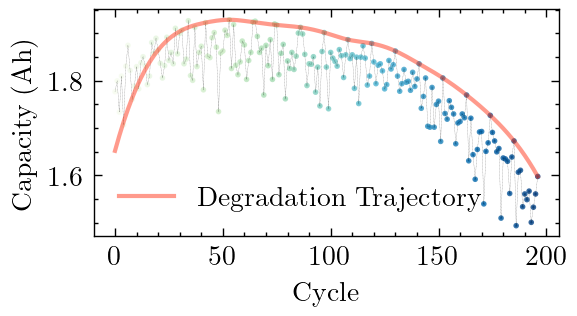

In [21]:
# 画容量退化曲线和退化轨迹
capacity = battery.get_capacity()
degradation_trajectory = battery.get_degradation_trajectory()
x = np.arange(len(capacity))
fig, ax = plt.subplots(figsize=(3, 1.5),dpi=200)
plt.plot(x,capacity,'--k',linewidth=0.1,alpha=0.6)
plt.scatter(x,capacity,c=cm,s=1,alpha=0.8)
plt.plot(degradation_trajectory,linewidth=1.5,alpha=0.5,c='#FF371B',label='Degradation Trajectory')
plt.xlabel('Cycle')
plt.ylabel('Capacity (Ah)')
plt.legend()
plt.show()


### 画电压、电流、温度曲线

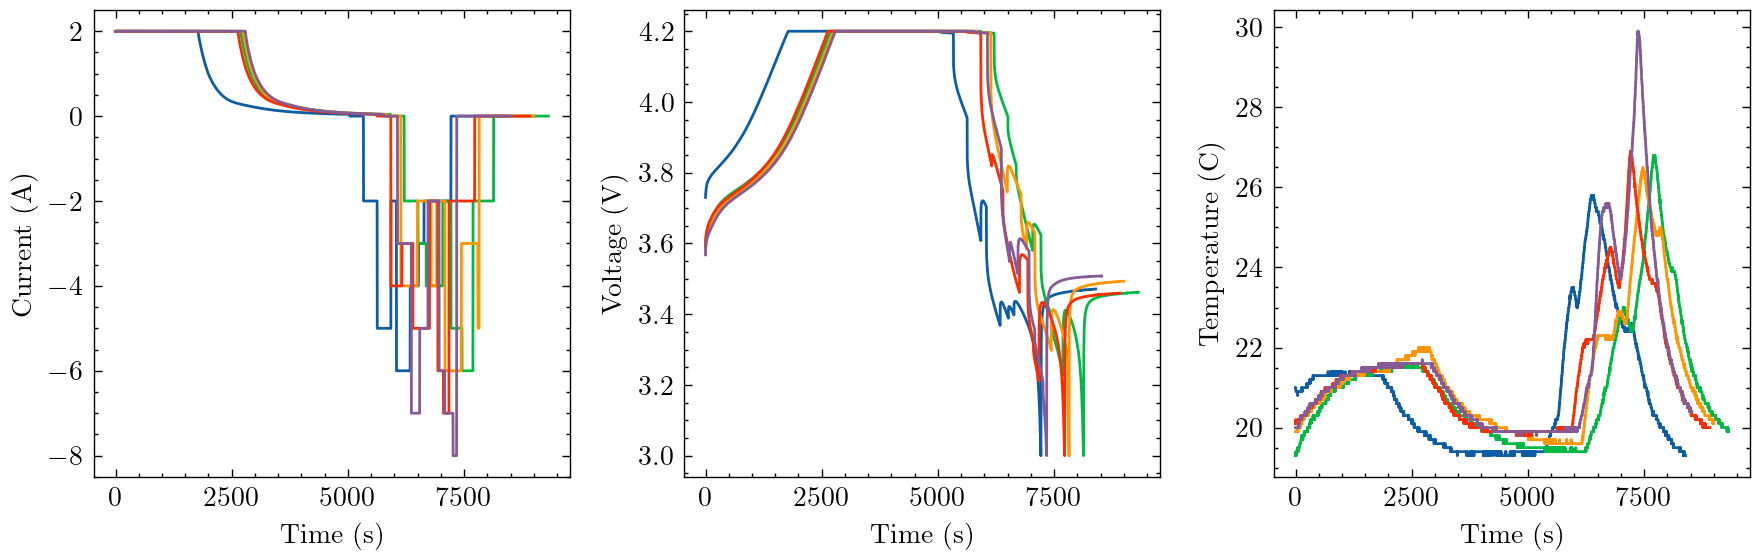

In [22]:
# 在1*3的图中随机画出5个cycle的电压、电流、温度曲线
fig, axs = plt.subplots(1, 3, figsize=(9, 3),dpi=200)
for i in range(1,6):
    current = battery.get_value(cycle=i,variable='current_A')
    voltage = battery.get_value(cycle=i,variable='voltage_V')
    temperature = battery.get_value(cycle=i,variable='temperature_C')
    axs[0].plot(current)
    axs[0].set_xlabel('Time (s)')
    axs[0].set_ylabel('Current (A)')
    axs[1].plot(voltage)
    axs[1].set_xlabel('Time (s)')
    axs[1].set_ylabel('Voltage (V)')
    axs[2].plot(temperature)
    axs[2].set_xlabel('Time (s)')
    axs[2].set_ylabel('Temperature (C)')
plt.tight_layout()
plt.show()

其他曲线的画法与Batch-1一致，不再赘述。

# Batch-6
## 数据集介绍
**模拟地球同步轨道（Geosynchronous Earth Orbit）卫星电池充放电。**
第一个cycle测量电池的初始容量：以0.5C（1A）恒流充电至4.2V，然后维持电压不变，直至电流降至0.02C（40mA）；静置5分钟；以0.2C（0.4A）放电至2.5V。

其他cycles：
以2C（4A）充电至4.2V，然后维持电压不变，直至电流降至0.05C（0.1A）；
静置5分钟，以0.667C（1.334A）放电，放电持续时间下表所示：


| Cycle number  | 1   | 2   | 3   | 4   | 5   | 6   | 7   | 8   | 9   | 10  | 11  | 12  | 13  | 14  | 15  | 16  | 17  | 18  | 19  | 20  | 21  | 22  | 23  |
| Cycle number  | 46  | 45  | 44  | 43  | 42  | 41  | 40  | 39  | 38  | 37  | 36  | 35  | 34  | 33  | 32  | 31  | 30  | 29  | 28  | 27  | 26  | 25  | 24  |
|---------------|-----|-----|-----|-----|-----|-----|-----|-----|-----|-----|-----|-----|-----|-----|-----|-----|-----|-----|-----|-----|-----|-----|-----|
| Duration (min)| 5   | 20  | 34  | 41  | 46  | 50  | 54  | 56  | 58  | 60  | 62  | 64  | 68  | 69  | 70  | 71  | 72  | 72  | 72  | 72  | 72  | 72  | 72  |


大约每5个cycle测一次容量（以1C（2A）恒流恒压充电至4.2V；静置5分钟；以0.5C（1A）放电至2.5V）。

## 案例和可视化

In [23]:
battery = Battery('../Batch-6/Sim_satellite_battery-1.mat')
cm = plt.cm.GnBu(np.linspace(0,1,battery.cycle_life))
sm = plt.cm.ScalarMappable(cmap='GnBu',norm=plt.Normalize(vmin=0,vmax=battery.cycle_life))

电池寿命：949, 电池描述：Simulate satellite


### 画容量退化曲线和退化轨迹
从Batch-4开始，所有电池都没有完全放电，因此用测试容量的cycle来插值，得到退化曲线。

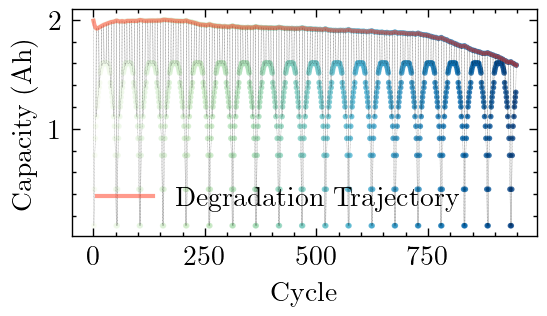

In [24]:
# 画容量退化曲线和退化轨迹
capacity = battery.get_capacity()
degradation_trajectory = battery.get_degradation_trajectory()
x = np.arange(len(capacity))
fig, ax = plt.subplots(figsize=(3, 1.5),dpi=200)
plt.plot(x,capacity,'--k',linewidth=0.1,alpha=0.6)
plt.scatter(x,capacity,c=cm,s=1,alpha=0.8)
plt.plot(degradation_trajectory,linewidth=1.5,alpha=0.5,c='#FF371B',label='Degradation Trajectory')
plt.xlabel('Cycle')
plt.ylabel('Capacity (Ah)')
plt.legend()
plt.show()

从上图可以看出，电池放电时间以46个cycle为周期，其放出的容量也呈示了周期性。

### 画电压、电流、温度曲线
画半次循环（23个cycle）的电压、电流、温度曲线

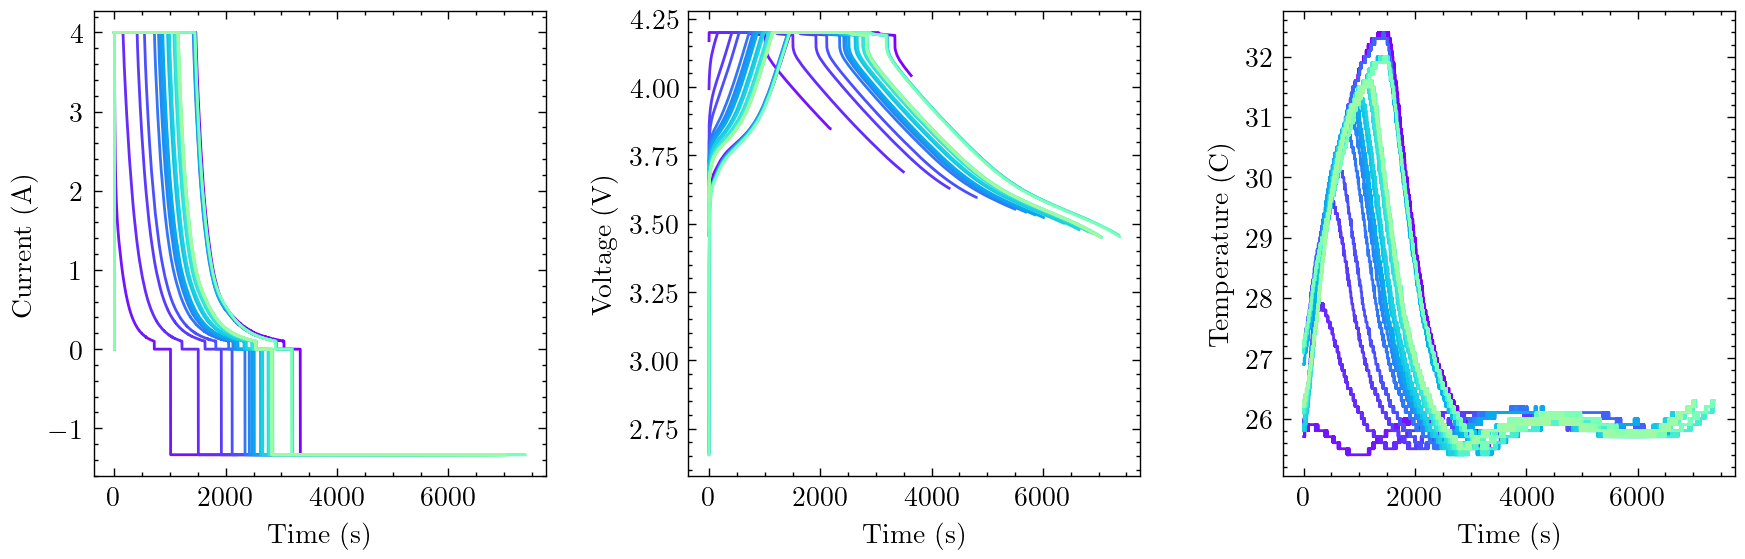

In [25]:
# 在1*3的图中画出23个cycle的电压、电流、温度曲线
fig, axs = plt.subplots(1, 3, figsize=(9, 3),dpi=200)
count = 0
cycle = 2
cm = plt.cm.rainbow(np.linspace(0,1,40))
while count < 23:
    description = battery.get_one_cycle_description(cycle=cycle)
    if 'test capacity' in description:
        cycle += 1
        continue
    current = battery.get_value(cycle=cycle,variable='current_A')
    voltage = battery.get_value(cycle=cycle,variable='voltage_V')
    temperature = battery.get_value(cycle=cycle,variable='temperature_C')
    color = cm[count]
    axs[0].plot(current,color=color)
    axs[0].set_xlabel('Time (s)')
    axs[0].set_ylabel('Current (A)')
    axs[1].plot(voltage,color=color)
    axs[1].set_xlabel('Time (s)')
    axs[1].set_ylabel('Voltage (V)')
    axs[2].plot(temperature,color=color)
    axs[2].set_xlabel('Time (s)')
    axs[2].set_ylabel('Temperature (C)')
    count += 1
    cycle += 1
plt.tight_layout()
plt.show()

把静置阶段的index对齐，重新绘制电压、电流、温度曲线

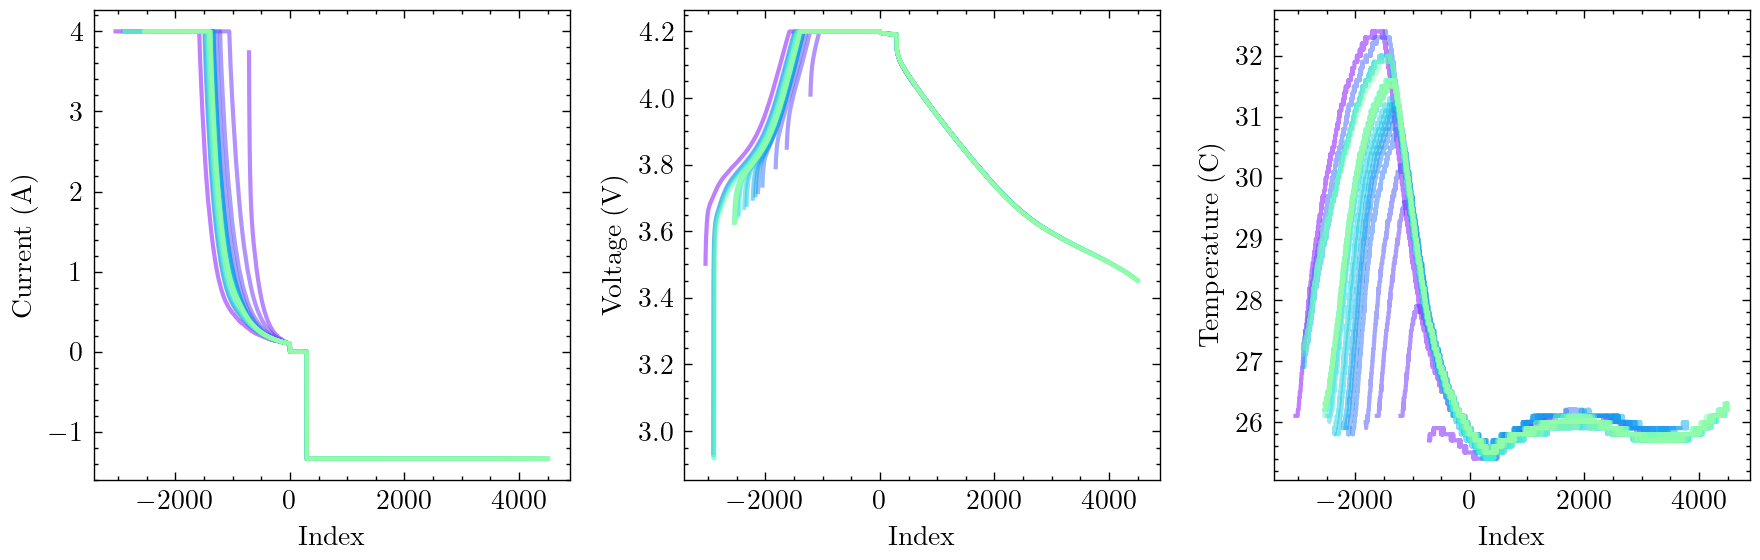

In [26]:
VOLTAGES_C = [] # 充电阶段电压
VOLTAGES_R = [] # 静置阶段电压
VOLTAGES_D = [] # 放电阶段电压
CURRENTS_C = []
CURRENTS_R = []
CURRENTS_D = []
TEMPERATURES_C = []
TEMPERATURES_R = []
TEMPERATURES_D = []
count = 0
cycle = 2
while count < 23:
    description = battery.get_one_cycle_description(cycle=cycle)
    if 'test capacity' in description:
        cycle += 1
        continue

    voltage_c = battery.get_partial_value(cycle=cycle,variable='voltage_V',stage=1)
    voltage_r = battery.get_partial_value(cycle=cycle,variable='voltage_V',stage=2)
    voltage_d = battery.get_partial_value(cycle=cycle,variable='voltage_V',stage=3)
    current_c = battery.get_partial_value(cycle=cycle,variable='current_A',stage=1)
    current_r = battery.get_partial_value(cycle=cycle,variable='current_A',stage=2)
    current_d = battery.get_partial_value(cycle=cycle,variable='current_A',stage=3)
    temperature_c = battery.get_partial_value(cycle=cycle,variable='temperature_C',stage=1)
    temperature_r = battery.get_partial_value(cycle=cycle,variable='temperature_C',stage=2)
    temperature_d = battery.get_partial_value(cycle=cycle,variable='temperature_C',stage=3)

    VOLTAGES_C.append(voltage_c[1:])
    VOLTAGES_R.append(voltage_r)
    VOLTAGES_D.append(voltage_d)
    CURRENTS_C.append(current_c[1:])
    CURRENTS_R.append(current_r)
    CURRENTS_D.append(current_d)
    TEMPERATURES_C.append(temperature_c[1:])
    TEMPERATURES_R.append(temperature_r)
    TEMPERATURES_D.append(temperature_d)

    count += 1
    cycle += 1

# 把voltage_c，voltage_r，voltage_d拼接起来得到voltage，并把voltage按照静置阶段的index对齐
INDEXS = []
VOLTAGES = []
CURRENTS = []
TEMPERATURES = []
for i in range(len(VOLTAGES_C)):
    # 把voltage_c，voltage_r，voltage_d拼接起来得到voltage，并把voltage按照voltage_r的index对齐
    voltage = np.concatenate((VOLTAGES_C[i],VOLTAGES_R[i],VOLTAGES_D[i]))
    current = np.concatenate((CURRENTS_C[i],CURRENTS_R[i],CURRENTS_D[i]))
    temperature = np.concatenate((TEMPERATURES_C[i],TEMPERATURES_R[i],TEMPERATURES_D[i]))
    index = np.arange(len(voltage))
    left_shift = len(VOLTAGES_C[i])
    index = index - left_shift
    VOLTAGES.append(voltage)
    CURRENTS.append(current)
    TEMPERATURES.append(temperature)
    INDEXS.append(index)

# 在1*3的图中画出23个cycle的电压、电流、温度曲线
fig, axs = plt.subplots(1, 3, figsize=(9, 3),dpi=200)
for i in range(len(VOLTAGES)):
    axs[0].plot(INDEXS[i],CURRENTS[i],linewidth=1.5,alpha=0.5,c=cm[i])
    axs[1].plot(INDEXS[i],VOLTAGES[i],linewidth=1.5,alpha=0.5,c=cm[i])
    axs[2].plot(INDEXS[i],TEMPERATURES[i],linewidth=1.5,alpha=0.5,c=cm[i])
    axs[0].set_xlabel('Index')
    axs[0].set_ylabel('Current (A)')
    axs[1].set_xlabel('Index')
    axs[1].set_ylabel('Voltage (V)')
    axs[2].set_xlabel('Index')
    axs[2].set_ylabel('Temperature (C)')
plt.tight_layout()
plt.show()


其他曲线的画法与Batch-1一致，不再赘述。